In [5]:
# Imports and data load
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# try common paths for the Mall Customers csv
df = pd.read_csv("ML470_S7_MallCustomers_Data_Concept.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Selected K = 6


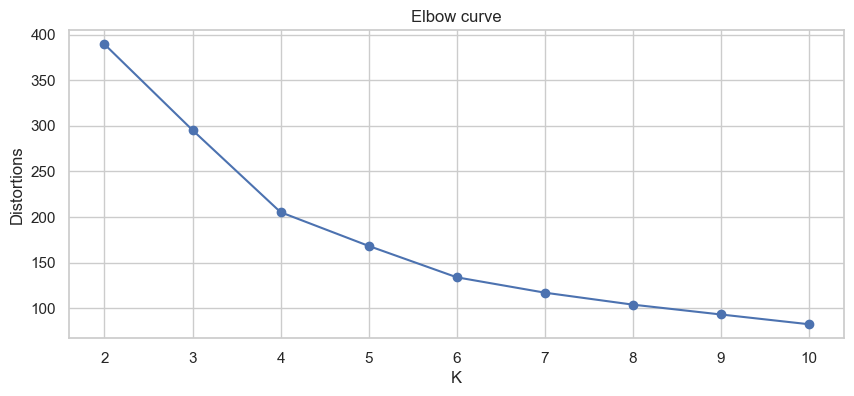

In [11]:
# Preprocess & scale
# pick columns (handle common column names)
candidates = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
for col in df.columns:
    pass
features = [c for c in candidates if c in df.columns]
if len(features) < 3:
    raise ValueError('Expected columns not found. Found: ' + str(df.columns.tolist()))

X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans: inertia (elbow) and silhouette for K=2..10
ks = list(range(2, 11))
inertias = []
sil_scores = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    # silhouette requires at least 2 clusters and less than n_samples
    try:
        sil = silhouette_score(X_scaled, labels)
    except Exception:
        sil = np.nan
    sil_scores.append(sil)

# Plot elbow and silhouette
plt.figure(figsize=(10,4))
plt.plot(ks, inertias, '-o')
plt.xlabel('K')
plt.ylabel('Distortions')
plt.title('Elbow curve')
plt.grid(True)

# choose best K using silhouette (fallback to elbow if NaN)
if np.all(np.isnan(sil_scores)):
    # choose elbow: first large drop -> here pick 4 as common default
    best_k = 4
else:
    best_k = ks[int(np.nanargmax(sil_scores))]
print('Selected K =', best_k)

In [7]:
# Agglomerative clustering and attach labels
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)
df['cluster'] = agg_labels.astype(int)
print(df['cluster'].value_counts().sort_index())

cluster
0    45
1    45
2    39
3    28
4    22
5    21
Name: count, dtype: int64


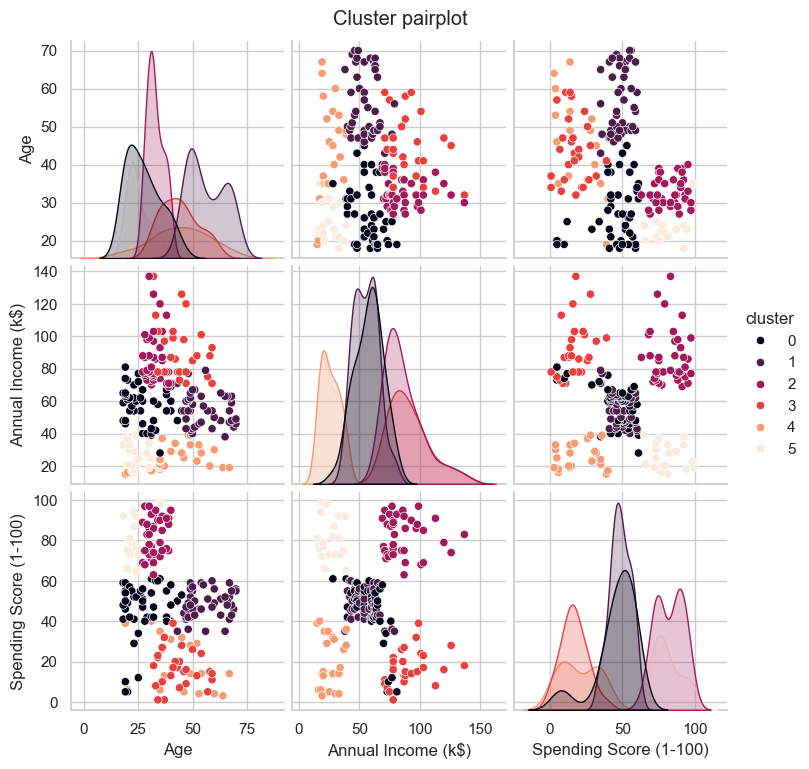

In [8]:
# Pairplot to visualize clusters
sns.set(style='whitegrid')
pairplot = sns.pairplot(df, vars=features, hue='cluster', palette='rocket', diag_kind='kde', corner=False)
pairplot.fig.suptitle('Cluster pairplot', y=1.02)
plt.show()

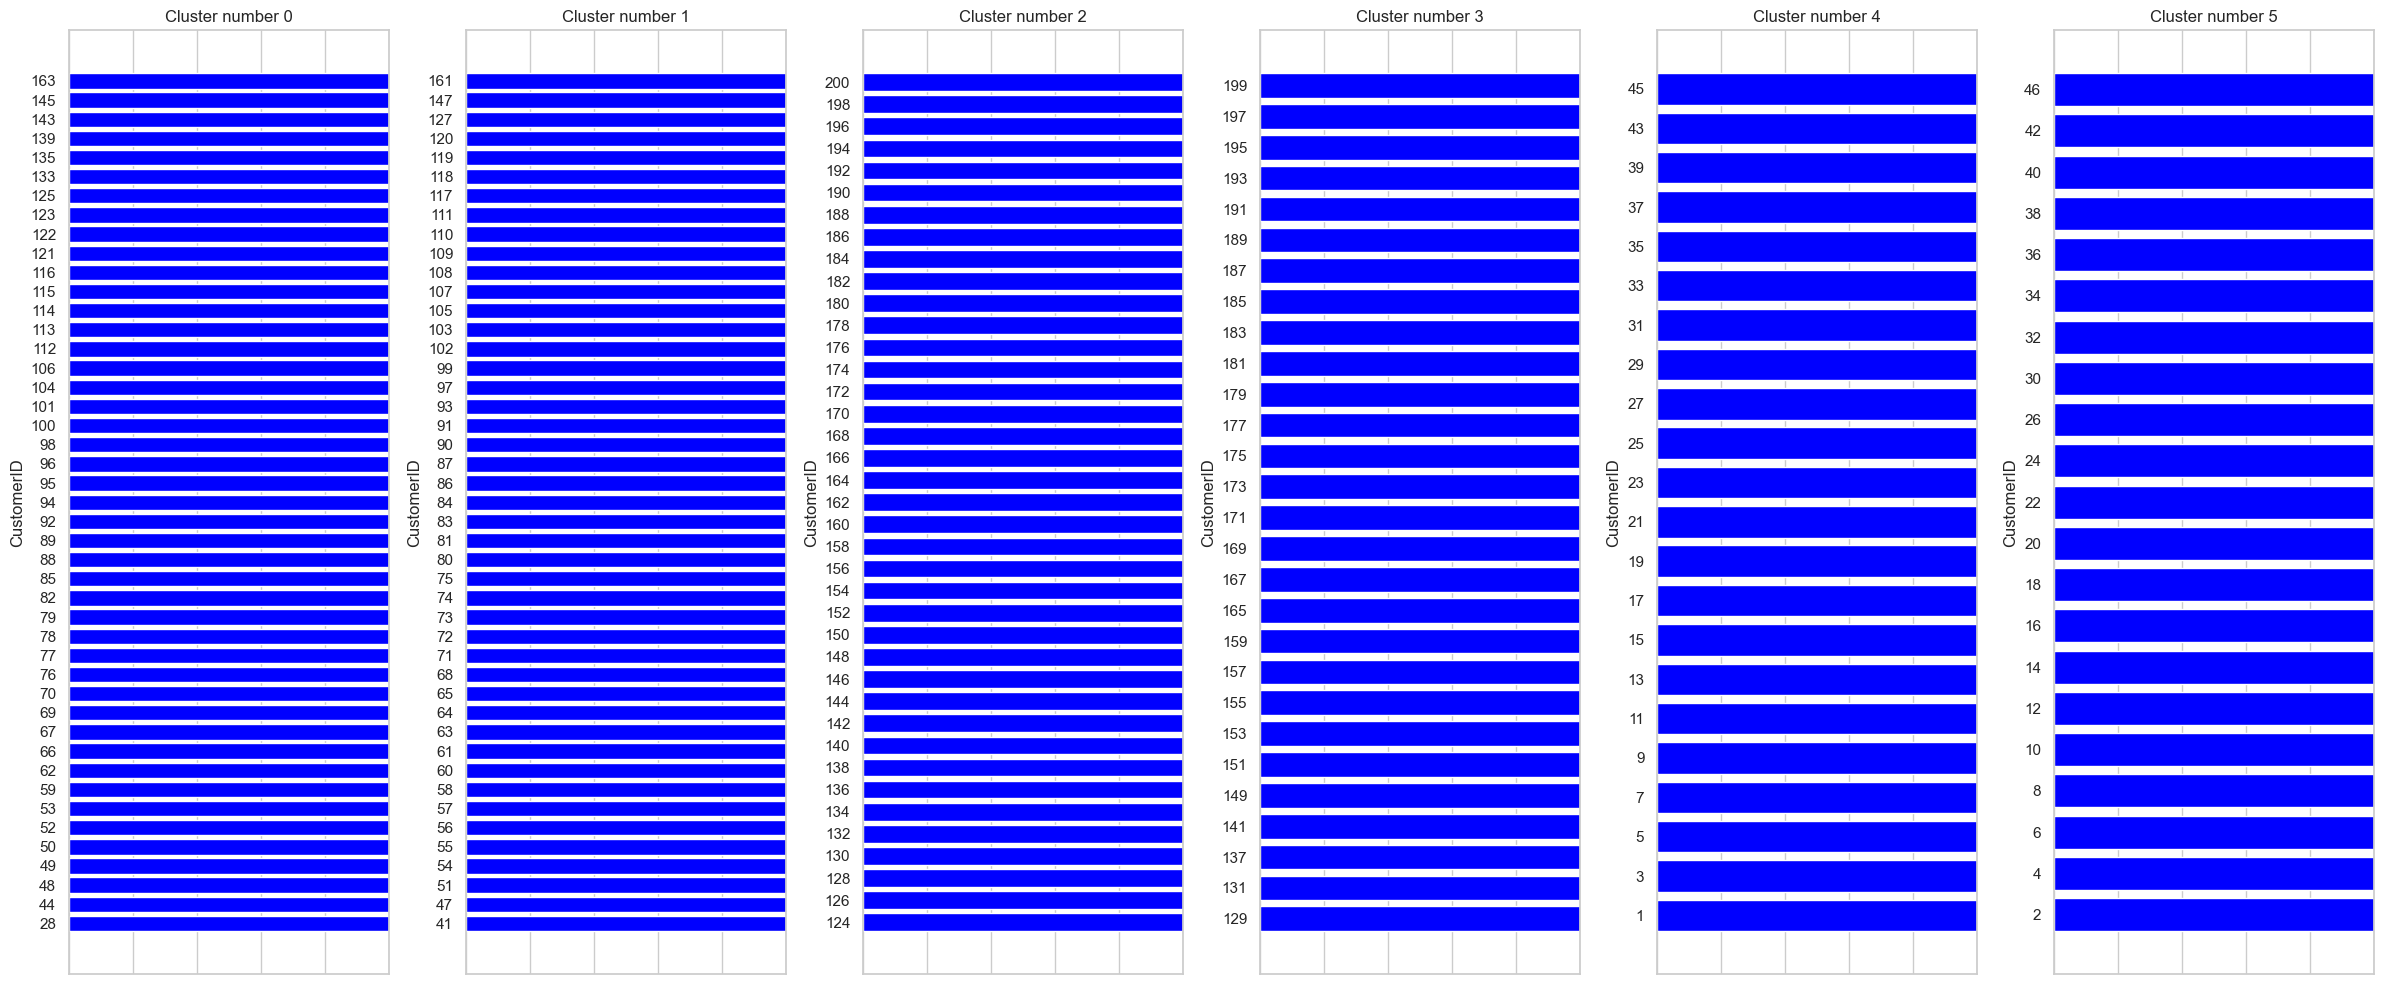

Cluster 0: count=45, unique ages=[np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27)]
Cluster 1: count=45, unique ages=[np.int64(43), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(53), np.int64(54), np.int64(55)]
Cluster 2: count=39, unique ages=[np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]
Cluster 3: count=28, unique ages=[np.int64(32), np.int64(33), np.int64(34), np.int64(36), np.int64(37), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44)]
Cluster 4: count=22, unique ages=[np.int64(19), np.int64(20), np.int64(31), np.int64(35), np.int64(36), np.int64(37), np.int64(40), np.int64(42), np.int64(45), np.int64(46)]
Cluster 5: count=21, unique ages=[np.int64(18), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25)

In [9]:
# Per-cluster horizontal bar subplots of CustomerID (one bar per customer)
cust_col = None
for c in ['CustomerID', 'Customer Id', 'Customer Id.']:
    if c in df.columns:
        cust_col = c
        break
if cust_col is None:
    # fallback to index
    df = df.reset_index().rename(columns={'index': 'CustomerID'})
    cust_col = 'CustomerID'

clusters = sorted(df['cluster'].unique())
n = len(clusters)
fig, axes = plt.subplots(1, n, figsize=(4*n, 10), sharex=True)
if n == 1:
    axes = [axes]
for ax, cl in zip(axes, clusters):
    sub = df[df['cluster'] == cl].sort_values(cust_col)
    y = sub[cust_col].astype(str)
    x = np.ones(len(y))
    ax.barh(y, x, color='blue')
    ax.set_title(f'Cluster number {cl}')
    ax.set_xlabel('')
    ax.set_xlim(0, 1)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.set_ylabel('CustomerID')
plt.tight_layout()
plt.show()

# Print unique ages and counts per cluster
for cl in clusters:
    grp = df[df['cluster'] == cl]
    print(f'Cluster {cl}: count={len(grp)}, unique ages={sorted(grp["Age"].unique())[:10]}', end='\n')